# Per capita emissions

The graph below shows that global per capita emissions have not grown greatly since the 1970s.

![Global per capita CO2 emissions](global.percap.gif)

However, the per capita emissions rates of some of the top 20 emitting countires has grown rapidly in recent years. For example, for China, the per capita rate grew from 0.95 in 2003 to 1.43 in 2008. At the same time, per capita emissions from the USA dropped slightly over that same period.




In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


def read_database(countries = None,
                    csv_file="nation.1751_2014.csv", 
                    url="https://cdiac.ess-dive.lbl.gov/ftp/ndp030/CSV-FILES/"):
    """Reads emissions database from local CSV file (or downloads it, 
    if not available). You can specify a list of countries to consider as well. 
    The returned Pandas data frame contains an estimate of population  
    calculated from the total emissions and per capita emission figures. The data
    are only considered after 1950"""
    csv_file = Path(f"./{csv_file:s}")

    if not csv_file.exists():
        csv_file = f"{url:s}/{csv_file:s}"

    df = pd.read_csv (csv_file, skiprows=[1,2,3],
                      parse_dates=['Year'],
                      date_parser=lambda x:pd.to_datetime(x, format='%Y'),
                     na_values="." )

    if countries is not None:
        df = df[
            (df['Year'] >= "1950-01-01")][(df['Nation'].isin(countries))]
    else:
        df = df[
            (df['Year'] >= "1950-01-01")]
        
    df.columns = ["Nation", "Year", "Total", "Solid",
                  "Liquid", "Gas", "Cement","Flaring",
                  "PerCapita", "Bunker"]
    df['PerCapita'] = df['PerCapita'].astype('float64')
    df['Population'] = 1000*df['Total'].values/df['PerCapita'].values
    return df[['Nation', "Year", "Population", "Total", "PerCapita"]]


# Read the database into a dataframe
df = read_database()
# Print the first few lines of the database
df.head()



/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide


,Nation,Year,Population,Total,PerCapita
1,AFGHANISTAN,1950-01-01,inf,23,0.0
2,AFGHANISTAN,1951-01-01,inf,25,0.0
3,AFGHANISTAN,1952-01-01,inf,25,0.0
4,AFGHANISTAN,1953-01-01,inf,29,0.0
5,AFGHANISTAN,1954-01-01,inf,29,0.0


#### Questions
Identify those countries in the top twenty emitting nations lists which have increasing trends in 

1.  population and,
2. per capita emissions rates. 

Rank them in order.

You can get subset the database by sorting by the `Total` emissions field for the last year of data. The Python code that does this using Pandas is shown below. You may also want to consider the *total historical* emissions, rather than a single date, or maybe the average of the last (say) 10 years for your ranking.

```python

df[df['Year']=="2014-01-01"].sort_values("Total", ascending=False)
```

The following snippet shows you how to plot the time series of different selected countries:

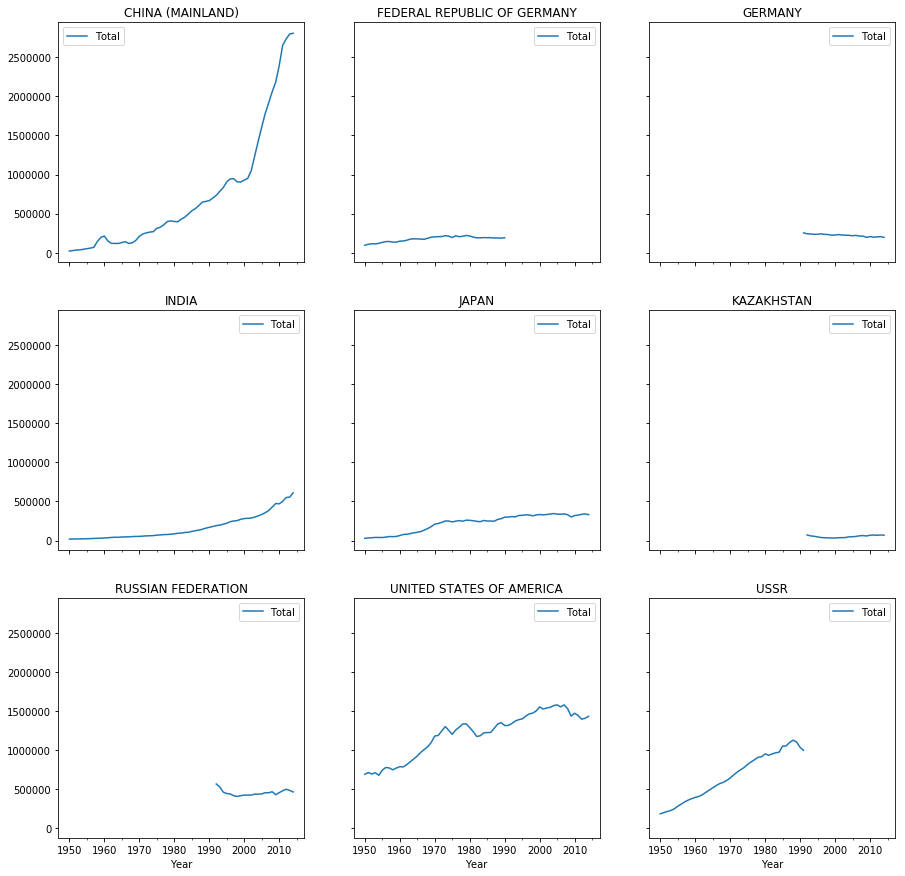

In [2]:
countries = [ "CHINA (MAINLAND)", "INDIA", "JAPAN", "FEDERAL REPUBLIC OF GERMANY",
                     "GERMANY", "USSR","KAZAKHSTAN",
                    "RUSSIAN FEDERATION", "UNITED STATES OF AMERICA"]
selected_countries_df = df[df["Nation"].isin(countries)].groupby("Nation")

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                       sharex=True, sharey=True)
axs = axs.flatten()

for i, (nation_name, totals) in enumerate(selected_countries_df):
    totals.plot(ax=axs[i],
                x="Year", y="Total", title=nation_name)


## Extrapolating emissions

The code below provides linear *extrapolation* of per capita emissions for the year 2020, based on the data from 1995 to 2008. The code is given as a Python function, and you'll be expected to modify it slightly (remember to change the function name!!!). The last line shows a demonstration of how to call the function as a user

array([ 7.89010989e-03, -1.55156264e+01])

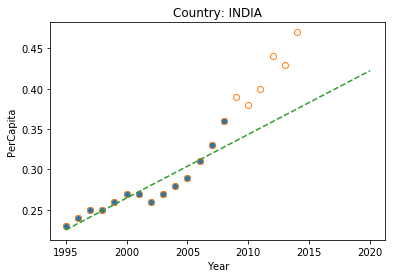

In [3]:
def fit_linear_model(df,
                     country,
                     field,
                     start_fit=1995,
                     end_fit=2008,
                     end_test=2020):
    """Fits a linear model to a particular field (given by `field`) of a given
    dataframe (`df`), where the fitting period is given.
    
    Parameters
    ------------
    df: Pandas dataframe
        A pandas dataframe. You can use the one that is available from the
        previous cells.
     country: string
         A country string. Make sure you get the country name to be the same
         as is in the database!
    field: string
        A database field, e.g. "PerCapita", "Total", etc.
    start_fit: integer
        Year where the fitting starts. By default, 1995.
    end_fit: integer
        Year where the fitting ends. By default, 2008
    end_test: integer
        Year until which you'll extrapolate your model.
        
    Returns the polynomial coefficients
    """
    start_date = f"{start_fit:d}-01-01"
    end_date = f"{end_fit:d}-01-01"
    selfit = df[(df.Year >= start_date) & (df.Year <= end_date) &
                (df.Nation == country)]
    X = selfit.Year.dt.year.values
    y = selfit[field].values
    p = np.polyfit(X, y, 1)
    plt.plot(X, y, 'o')

    testfit = df[(df.Year >= start_date) & (df.Year <= "2014-01-01") &
                 (df.Nation == country)]
    X = testfit.Year.dt.year.values
    y = testfit[field].values
    plt.plot(X, y, 'o', mfc="none")

    Xx = np.arange(start_fit, end_test + 1)

    plt.plot(Xx, np.polyval(p, Xx), '--')
    plt.title(f"Country: {country:s}")
    plt.ylabel(field)
    plt.xlabel("Year")
    return p


fit_linear_model(df, "INDIA", "PerCapita")

#### Questions
* Adapt the code so that it provides estimates of Total Fossil-Fuel Emissions for 2020 for the top 20 emitting countries, assuming population does not increase.
* Adapt the code so that it provides estimates of Total Fossil-Fuel Emissions for 2020 for the top 20 emitting countries, assuming a linear trend in population.
* Use these two sets of figures to estimate the impact of population growth on total (global) Fossil-Fuel Emissions for 2020 (i.e. what proportion of the change in estimated emissions can be attributed to population growth?). You can assume that the proportion of emissions from the top 20 countries remains at 63% if you need that information.
* What impact does the time period over which you perform the linear regression have (e.g. change it to start at 2000)?
* If you have time, you might try to estimate the uncertainty on these estimates.
* Criticise the model developed. What factors might come into play that we have not accounted for here (a starter: global economic conditions; also, have we missed any important countries)?